In [1]:
# testing out CNN

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
import wfdb
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import math
from sklearn.utils.class_weight import compute_class_weight
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pywt
import funcs
import keras

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
path = "pickled/"
trainReadings = funcs.unpickler(path + 'train_readings.pkl')
trainDiagnostic = funcs.unpickler(path + 'train_diagnostic.pkl')
validateReadings = funcs.unpickler(path + 'validate_readings.pkl')
validateDiagnostic = funcs.unpickler(path + 'validate_diagnostic.pkl')
testReadings = funcs.unpickler(path + 'test_readings.pkl')
testDiagnostic = funcs.unpickler(path + 'test_diagnostic.pkl')

oneHotTrain = funcs.one_hot_encoder(trainDiagnostic, 2)
oneHotValidate = funcs.one_hot_encoder(validateDiagnostic, 2)
oneHotTest = funcs.one_hot_encoder(testDiagnostic, 2)

In [6]:
# data is imbalanced so we balance it

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(trainDiagnostic),
                                        y = trainDiagnostic                                                    
                                    )
class_weights = dict(zip(np.unique(trainDiagnostic), class_weights))

sigmoidLoss = keras.losses.BinaryCrossentropy(); # one output unit
softmaxLoss = keras.losses.CategoricalCrossentropy(); # two output units

In [7]:
def make_for_cnn(data, scale):
    transform = []
    for i in data:
        transform.append(pywt.cwt(i, scales, 'mexh')[0].T)
    return np.array(transform)

In [8]:
scales = np.linspace(0.1, 1, 10) # scales to use for cwt

trainTransform = make_for_cnn(trainReadings, scales)
validateTransform = make_for_cnn(validateReadings, scales)
testTransform = make_for_cnn(testReadings, scales)

trainTransform.shape

(10977, 1000, 10)

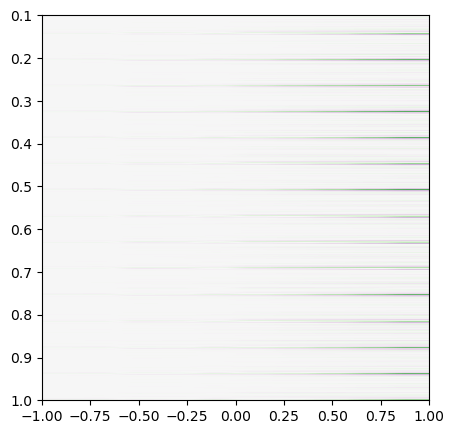

In [9]:
plt.figure(figsize=(5, 5))
plt.imshow(trainTransform[0], extent=[-1, 1, 1, 0.1], cmap='PRGn', aspect='auto',
           vmax=abs(trainTransform[0]).max(), vmin=-abs(trainTransform[0]).max())

In [10]:
inputShape = (32, 1000, len(scales))
kernelSize = 10

In [28]:
import os
currentDirectory = os.getcwd()
fileName = 'best.hdf5' # model weights are stored in hdf5 file
checkpointFile = os.path.join(currentDirectory, 'ckpt', fileName)

checkpoint = callbacks.ModelCheckpoint(filepath=checkpointFile, 
                                       save_weights_only=True, 
                                       monitor='val_accuracy',
                                       mode='max', #save when the val accuracy is the highest
                                       save_best_only=True, 
                                      )

In [29]:
from keras.models import Sequential
from keras import layers, metrics, callbacks

In [30]:
#should we try using a rectangular kernel size?

convInputLayer = layers.Conv1D(
    filters=64, kernel_size=kernelSize, input_shape=inputShape[1:], data_format="channels_last")
convLayer = layers.Conv1D(
    filters=32, kernel_size=kernelSize)
batchNormLayer = layers.BatchNormalization(axis=1)
reLULayer = layers.ReLU()
maxPoolLayer = layers.MaxPooling1D(
    pool_size=kernelSize, strides=None) # should the size of the pooling layer be the same as the kernel size

In [75]:
model = Sequential()

model.add(convLayer)
model.add(batchNormLayer)
model.add(maxPoolLayer)

model.add(convLayer)
model.add(batchNormLayer)
model.add(maxPoolLayer)

model.add(convLayer)
model.add(batchNormLayer)
model.add(maxPoolLayer)

model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [76]:
model.compile(
    optimizer='adam', loss=softmaxLoss, 
 metrics=['accuracy',tf.keras.metrics.FalsePositives()])

In [77]:
history = model.fit(
    trainTransform, oneHotTrain, 
    epochs=150, 
    class_weight=class_weights, 
    validation_data=(validateTransform, oneHotValidate), 
    callbacks=checkpoint)

Epoch 1/150
343/344 [============================>.] - ETA: 0s - loss: 0.6703 - accuracy: 0.5835 - false_positives_5: 4572.0000

KeyboardInterrupt: 

In [73]:
def graph_losses(history, fig_size):
    history = history.history
    plt.figure(figsize=fig_size)
    plt.plott(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

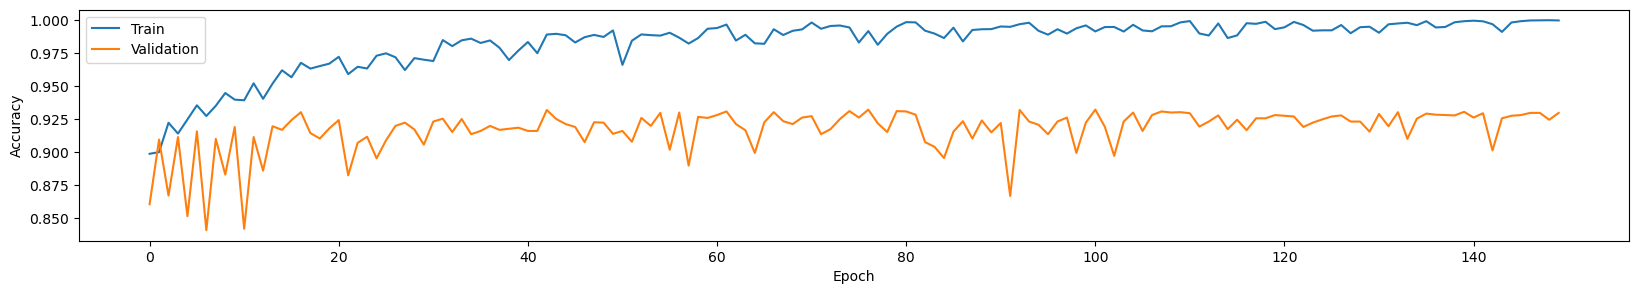

In [74]:
graph_losses(history, (20, 3))

In [53]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'false_positives_3', 'val_loss', 'val_accuracy', 'val_false_positives_3'])


In [35]:
model.load_weights(checkpointFile)

In [ ]:
funcs.evaluate_model(model.predict(testTransform), oneHotTest)